In [49]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm

from utils import plot_segmentation, color_mappings
from segmentation import Segmentor

from config import MODEL_DIRECTORY

# ignore tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### instantiate the segmentor and number of models you want to use, this only needs to be done once

In [41]:
# recommended to use all 5 available models
NUM_MODELS = 5

model_directory = MODEL_DIRECTORY
segmentor = Segmentor(model_directory, n_models = NUM_MODELS)

# see available models
segmentor.model_paths

[PosixPath('/Users/hannah.spitzer/projects/LODE/feature_segmentation/segmentation_ensembles/80/weights.hdf5'),
 PosixPath('/Users/hannah.spitzer/projects/LODE/feature_segmentation/segmentation_ensembles/81/weights.hdf5'),
 PosixPath('/Users/hannah.spitzer/projects/LODE/feature_segmentation/segmentation_ensembles/79/weights.hdf5'),
 PosixPath('/Users/hannah.spitzer/projects/LODE/feature_segmentation/segmentation_ensembles/83/weights.hdf5'),
 PosixPath('/Users/hannah.spitzer/projects/LODE/feature_segmentation/segmentation_ensembles/82/weights.hdf5')]

### load any Spectralis oct image and predict with available models 

In [42]:
# load own image
img_path = "./example_oct/4642_Right_20171019_576314001.png"
oct_ = cv2.imread(img_path)

# returns the segmented oct as a numpy array
seg_map = segmentor.segment(oct_)


plot = plot_segmentation(seg_map, show_legend=True, show_legend_text=True)
plt.show()
plt.imshow(oct_)
plt.show()

/Users/hannah.spitzer/projects/LODE/oct_segmentation_app/utils.py:64: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  c_bar = plt.colorbar(seg_plot, cmap=seg_cmap, norm=seg_norm, boundaries=bounds, fraction=0.4)
/Users/hannah.spitzer/projects/LODE/oct_segmentation_app/utils.py:64: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  c_bar = plt.colorbar(seg_plot, cmap=seg_cmap, norm=seg_norm, boundaries=bounds, fraction=0.4)


## Load OCT dicom file

In [45]:
from pydicom import read_file
def get_oct_slice(data_table, slice_no=24):
    # convert to grayscale
    s = data_table.pixel_array[slice_no]
    oct_ = np.array([s,s,s]).transpose(1,2,0)
    return oct_

pr = "/Users/hannah.spitzer/projects/LODE/data/Doktor Whatson OCT/Whatson_Doktor_20210629_20210629_1803_Spectralis_Bild_OD_1.3.6.1.4.1.33437.10.4.9457825.13269456262.8699.4.1.dcm"
pl = "/Users/hannah.spitzer/projects/LODE/data/Doktor Whatson OCT/Whatson_Doktor_20210629_20210629_1804_Spectralis_Bild_OS_1.3.6.1.4.1.33437.10.4.9457825.13269456263.8699.4.1.dcm"

data_table = read_file(pr)
oct_volume = data_table.pixel_array

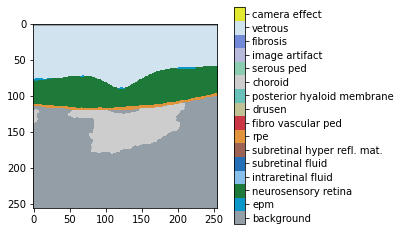

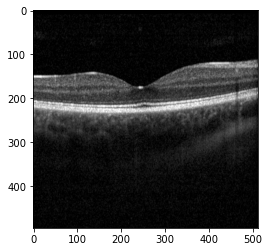

In [47]:
%matplotlib inline
oct_ = get_oct_slice(data_table, slice_no=23)
# returns the segmented oct as a numpy array
seg_map = segmentor.segment(oct_)

plot = plot_segmentation(seg_map, show_legend=True, show_legend_text=True)
plt.show()
plt.imshow(oct_)
plt.show()

## segment all slices and display interactively

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

def cube_show_slider(cube, axis=0, **kwargs):
    """
    Display a 3d ndarray with a slider to move along the third dimension.

    Extra keyword arguments are passed to imshow
    """
    import matplotlib.pyplot as plt
    from matplotlib.widgets import Slider, Button, RadioButtons

    # check dim
    if not cube.ndim == 3:
        raise ValueError("cube should be an ndarray with ndim == 3")

    # generate figure
    fig = plt.figure()
    ax = plt.subplot(111)
    fig.subplots_adjust(left=0.25, bottom=0.25)

    # select first image
    s = [slice(0, 1) if i == axis else slice(None) for i in range(3)]
    im = cube[s].squeeze()

    # display image
    l = ax.imshow(im, **kwargs)

    # define slider
    axcolor = 'lightgoldenrodyellow'
    ax = fig.add_axes([0.25, 0.1, 0.65, 0.03]) #, axisbg=axcolor)

    slider = Slider(ax, 'Axis %i index' % axis, 0, cube.shape[axis] - 1,
                    valinit=0, valstep=1, valfmt='%i')

    def update(val):
        ind = int(slider.val)
        s = [slice(ind, ind + 1) if i == axis else slice(None)
                 for i in range(3)]
        im = cube[s].squeeze()
        l.set_data(im)
        fig.canvas.draw()

    slider.on_changed(update)

    plt.show()

In [50]:
segmented_oct_volume = []
for slice_no in tqdm.tqdm(range(49)):
    oct_ = get_oct_slice(data_table, slice_no=slice_no)
    # returns the segmented oct as a numpy array
    segmented_oct_volume.append(segmentor.segment(oct_))
segmented_oct_volume = np.array(segmented_oct_volume)

100%|██████████| 49/49 [03:40<00:00,  4.49s/it]


In [82]:
%matplotlib widget

cube_show_slider(oct_volume, cmap='gray')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-80-1f8e8f3c74f2>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im = cube[s].squeeze()


In [83]:
%matplotlib widget

seg_cmap, seg_norm, bounds = color_mappings()
cube_show_slider(segmented_oct_volume, cmap=seg_cmap, norm=seg_norm, interpolation='none')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-80-1f8e8f3c74f2>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im = cube[s].squeeze()
